In [ ]:
import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import LogExpectedImprovement, UpperConfidenceBound
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
import numpy as np
import matplotlib.pyplot as plt

def poly(x):
    return (-0.001 * x**6 + 0.003 * x**5 + 0.062 * x**4 - 
            0.174 * x**3 - 0.673 * x**2 + 1.323 * x + 1.764)

In [3]:
train_X = np.random.uniform(low = -5, high = 5, size = 10)
Y = poly(train_X)
Y = torch.tensor(Y.reshape(-1,1))# + 0.1 * torch.randn_like(Y)  # add some noise
train_X = torch.tensor(train_X.reshape(-1,1))

In [4]:
gp = SingleTaskGP(
  train_X=train_X,
  train_Y=Y,
  input_transform=Normalize(d=1),
  outcome_transform=Standardize(m=1),
)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

logEI = LogExpectedImprovement(model=gp, best_f=Y.max())


In [5]:
bounds = torch.stack([torch.zeros(1), torch.ones(1)]).to(torch.double)
candidate, acq_value = optimize_acqf(
  logEI, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)
candidate  # tensor([[0.2981, 0.2401]], dtype=torch.float64)

tensor([[0.]], dtype=torch.float64)

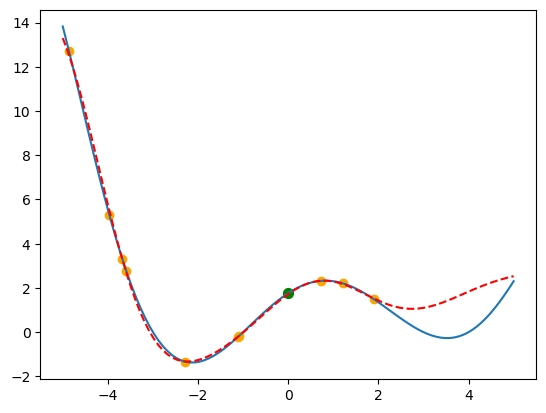

In [17]:
plot_x = np.linspace(-5,5,100)
plot_y = poly(plot_x)
plot_x_tensor = torch.tensor(plot_x.reshape(-1,1))
with torch.no_grad():
    gp_mean, gp_var = gp.posterior(plot_x_tensor).mean, gp.posterior(plot_x_tensor).variance


plt.plot(plot_x,plot_y)
plt.scatter(train_X,Y, color = 'orange')
plt.plot(plot_x_tensor.numpy(), gp_mean.numpy(), label="GP Mean", color="red", linestyle='dashed')
plt.scatter(candidate, poly(candidate), color = 'green', marker='o', s= 50)

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

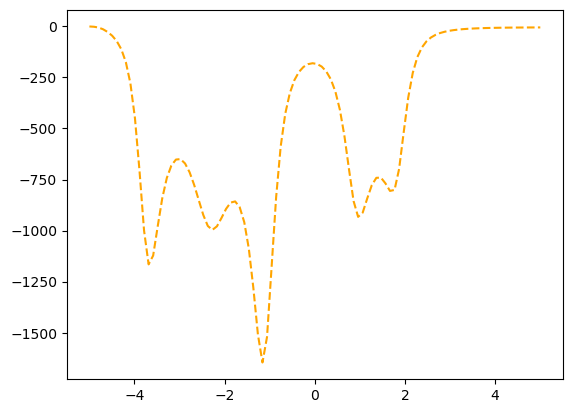

In [18]:
EI = logEI(plot_x_tensor.unsqueeze(-2)).detach()
plt.plot(plot_x_tensor.numpy(), EI.numpy(), color="orange", linestyle='dashed')
plt.scatter()